In [ ]:
import sys
sys.path.append("../src")
import lightbeam
from lightbeam.mesh import RectMesh3D, RectMesh2D
import lightbeam.optics as optics
from lightbeam import LPmodes
from lightbeam.misc import normalize
from lightbeam.prop import Prop3D

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider

In [ ]:
# wavelength: 1.5 um
# background (capillary) index: 1.4345
# SM cladding index: 1.44
# SM core index: 1.4522895
# T (taper ratio): 10
# Cladding output diameter: 328 um
# Cladding input diameter: 32.8 um (ie 328/T)
# SM core diam: 6.5 um
# SM core separation (on hex grid): 60 um

wl = 1.5 # um
njack = 1.4345
nclad = 1.44
ncore = 1.4522895
mm_rjack = 76.3 # um
mm_rclad = 32.8 # um
taper_ratio = 10
sm_rcore = 6.5 # um
mm_rjack = 76.3 # um
sm_rclad = 32.8 # um
sm_seperation_final = 2*60 # um
# # what is MM core radius assuming 2 um from http://dx.doi.org/10.1364/AOP.7.000107, 
# # measurements of figure 6 c): 570, 105
# mm_rcore = 28 # um ROUGH GUESS
sm_offset = 100
sm_ex = 5000
scale_func = None
l = 2
m = 2

In [ ]:
xw = 100 #um
yw= 100 #um
zw = sm_ex #um
num_PML = 10 #grid units

ds = 0.5 #um
dz = 10 #um

_mesh = RectMesh3D(xw,yw,zw,ds,dz,num_PML)
_mesh.xy.plot_mesh()

In [ ]:
lant19_ipos = optics.lant19.get_19port_positions(core_spacing=sm_seperation_final/taper_ratio)
clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_offset,nclad,njack,0,scale_func=scale_func,final_scale=1)
clad_sm = optics.scaled_cyl([0,0],sm_rclad,sm_ex,nclad,njack,sm_offset,scale_func=scale_func,final_scale=taper_ratio)
elmnts = [clad_mm, clad_sm]

for i in range(0,len(lant19_ipos)):
    core = optics.scaled_cyl(xy=lant19_ipos[i] ,r = sm_rcore/taper_ratio,z_ex = sm_ex,n = ncore,nb = nclad,z_offset=sm_offset,scale_func=scale_func,final_scale=taper_ratio) # fxy=lant19_fpos[i]
    elmnts.append(core)

lant19 = optics.OpticSys(elmnts,njack)
lant19.set_sampling(_mesh.xy)

out1 = np.zeros(_mesh.xy.shape)

# fig, axs = plt.subplots(1, 1, figsize=(7.5,7.5))
# ax_slider = plt.axes([0.2, 0.05, 0.65, 0.03], facecolor='lightgoldenrodyellow')
# slider = Slider(ax_slider, 'Z value', 0, sm_ex, valinit=0, valstep=1)

# lant19.set_IORsq(out, 0)
# im = axs.imshow(out, vmin=njack*njack, vmax=ncore*ncore)
# axs.set_title(f"z = 0")
# # Define the update function for the slider
# def update(val):
#     z_value = int(slider.val)
#     out = np.zeros(_mesh.xy.shape)
#     lant19.set_IORsq(out, z_value)
#     im.set_data(out)
#     axs.set_title(f"z = {z_value}")
#     fig.canvas.draw_idle()

# # Attach the update function to the slider
# slider.on_changed(update)

# plt.show()

# Create the figure and axes for the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Generate the first subplot
lant19.set_IORsq(out1, 0)
lims = [500,800]
# axs[0].set_xlim(lims)
# axs[0].set_ylim(lims)
# axs[0].set_xlabel('"Zoomed in"')
axs[0].imshow(out1, vmin=njack*njack, vmax=ncore*ncore)
axs[0].set_title(f"Multimode input || z = 0 to {sm_offset}")

# Generate the second subplot
lant19.set_IORsq(out1, sm_offset)
# axs[1].set_xlim(lims)
# axs[1].set_ylim(lims)
# axs[1].set_xlabel('"Zoomed in"')
axs[1].imshow(out1, vmin=njack*njack, vmax=ncore*ncore)
axs[1].set_title(f"Single mode before taper || z = {sm_offset}")

# # Generate the third subplot
# lant19.set_IORsq(out1, sm_ex)
# axs[2].imshow(out1, vmin=njack*njack, vmax=ncore*ncore)
# axs[2].set_title(f"Single mode output || z = {sm_ex}")
# # Display the figure with the subplots
# plt.tight_layout()
# plt.show()

#_mesh.xy.plot_mesh()

In [ ]:
import lightbeam.LPmodes as LPmodes
from lightbeam.misc import normalize

xg, yg = _mesh.xg[num_PML:-num_PML,num_PML:-num_PML],_mesh.yg[num_PML:-num_PML,num_PML:-num_PML]
u0 = normalize(LPmodes.lpfield(xg,yg,l,m,mm_rclad,wl,nclad,njack))
u1 = normalize(LPmodes.lpfield(xg,yg,4,4,mm_rclad,wl,nclad,njack))
u2 = normalize(LPmodes.lpfield(xg,yg,1,2,mm_rclad,wl,nclad,njack))

print(u0[0,0])
print((0+1j)*u0[0,0])

plt.imshow(np.abs((1+0j)*u0 + (1+0j)*u1 + (1+0j)*u2))
plt.show()
print("input field: ")
plt.imshow(np.abs(u0))
plt.show()

#### propagation ####

from lightbeam.prop import Prop3D

prop = Prop3D(wl,_mesh,lant19,nclad)

In [ ]:
u0 = prop.prop2end(u0)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
print("output field: ")
plt.imshow(np.abs(u0))
plt.show()

**Seperating the light propogation between the different meshes for each object**


In [ ]:
# wavelength: 1.5 um
# background (capillary) index: 1.4345
# SM cladding index: 1.44
# SM core index: 1.4522895
# T (taper ratio): 10
# Cladding output diameter: 328 um
# Cladding input diameter: 32.8 um (ie 328/T)
# SM core diam: 6.5 um
# SM core separation (on hex grid): 60 um
%matplotlib inline
wl = 1.5 # um
njack = 1.4345
nclad = 1.44
ncore = 1.4522895
mm_rjack = 76.3 # um
mm_rclad = 32.8 # um
taper_ratio = 10
sm_rcore = 6.5 # um
mm_rjack = 76.3 # um
sm_rclad = 32.8 # um
sm_seperation_initial = 2*sm_rcore # um
sm_seperation_final = 2*60 # um TEMP
sm_offset = 100
sm_ex = 40000
scale_func = None
ref_val = 2e-4
l = 2
m = 2

In [ ]:
ds = 0.5 #um
dz = 0.5 #um
iw = 100 #um
zw = sm_offset #um
num_PML = round(mm_rclad) #grid units

_mesh = RectMesh3D(iw,iw,zw,ds,dz,num_PML)
_mesh.xy.plot_mesh()

clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_offset,nclad,njack,0,scale_func=scale_func,final_scale=1)

mm = optics.OpticSys([clad_mm],njack)

xg, yg = _mesh.xg,_mesh.yg
u0 = normalize(LPmodes.lpfield(xg,yg,l,m,mm_rclad,wl,nclad,njack))
print(f"xg shape: {xg.shape}")
print(f"yg shape: {yg.shape}")
print(f"u0 shape: {u0.shape}")

print("input field: ")
plt.imshow(np.abs(u0))
plt.show()
# _mesh.xy.refine_base(u0,ref_val)
# mm.set_sampling(_mesh.xy)
_mesh.xy.plot_mesh()
prop = Prop3D(wl,_mesh,mm,njack)
u0 = prop.prop2end_uniform(u0)
print("output field: ")
plt.imshow(np.abs(u0))
plt.show()

In [ ]:
ds = 0.8 #um
dz = 10 #um
iw = 600 #um
zw = sm_ex #um
num_PML = 70 #grid units

_mesh = RectMesh3D(iw,iw,zw,ds,dz,num_PML)

lant19_ipos = optics2.lant19.get_19port_positions(core_spacing=sm_seperation_initial)
lant19_fpos = optics2.lant19.get_19port_positions(core_spacing=sm_seperation_final)

#lant19pos = optics.lant19.get_19port_positions(core_spacing=sm_rcore)
clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_ex,nclad,njack,0,scale_func=scale_func,final_scale=1)
clad_sm = optics.scaled_cyl([0,0],sm_rclad,sm_ex,nclad,njack,0,scale_func=scale_func,final_scale=taper_ratio)
elmnts = [clad_mm, clad_sm]

for i in range(0,len(lant19_ipos)):
    core = optics2.scaled_cyl(xy=lant19_ipos[i],fxy=lant19_fpos[i] ,r = sm_rcore/taper_ratio,z_ex = sm_ex,n = ncore,nb = nclad,z_offset=0,scale_func=scale_func,final_scale=taper_ratio)
    elmnts.append(core)

lant19 = optics.OpticSys(elmnts,njack)
lant19.set_sampling(_mesh.xy)

out = np.zeros(_mesh.xy.shape)
# Create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Generate the first subplot
lant19.set_IORsq(out, 0)
# axs[0].set_xlim([300,500])
# axs[0].set_ylim([300,500])
axs[0].imshow(out, vmin=njack*njack, vmax=ncore*ncore)

# Generate the second subplot
lant19.set_IORsq(out, 100)
# axs[1].set_xlim([300,500])
# axs[1].set_ylim([300,500])
axs[1].imshow(out, vmin=njack*njack, vmax=ncore*ncore)

# Display the figure with the subplots
plt.tight_layout()
plt.show()
xg, yg = _mesh.xg,_mesh.yg
# u0 = normalize(LPmodes.lpfield(xg,yg,l,m,mm_rclad,wl,nclad,njack))
print(f"xg shape: {xg.shape}")
print(f"yg shape: {yg.shape}")
print(f"u0 shape: {u0.shape}")

print("input field: ")
plt.imshow(np.abs(u0))
plt.show()
# _mesh.xy.refine_base(u0,ref_val)
# mm.set_sampling(_mesh.xy)
prop = Prop3D(wl,_mesh,lant19,nclad)
u1 = prop.prop2end_uniform(u0)
print("output field: ")
plt.imshow(np.abs(u1))
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
print("output field: ")
plt.imshow(np.abs(u1))
plt.show()

launch field


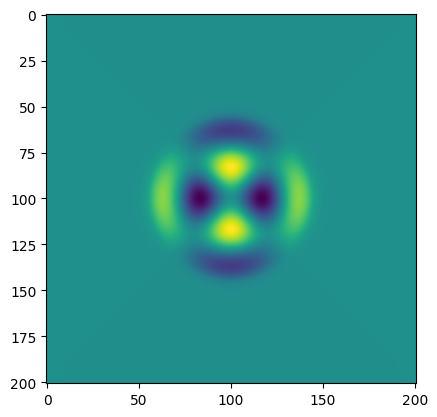

input power:  0.9999999999999999
propagating field...
initial shape:  (775, 775)
final total power 0.9988480447152337██████████████████████████████████████████████--------------------| 80.0% 
'prop2end'  645.7696 s


In [1]:
''' example script for running the beamprop code in prop.py'''
import numpy as np
import sys
sys.path.append("../src")
import lightbeam
from lightbeam.mesh import RectMesh3D
from lightbeam.prop import Prop3D
from lightbeam.misc import normalize,overlap_nonu,norm_nonu
from lightbeam import LPmodes
import matplotlib.pyplot as plt
from config_example import *

wl = 1.5 # um
njack = 1.4345
nclad = 1.44
ncore = 1.4522895
mm_rjack = 76.3 # um
mm_rclad = 32.8 # um
taper_ratio = 1
sm_rcore = 6.5 # um
mm_rjack = 76.3 # um
sm_rclad = 32.8 # um
sm_seperation_final = 2*(sm_rcore + 0.1) # 2*60 # um
sm_offset = 0 # um
sm_ex = 500 # um
scale_func = None
l = 2
m = 2

xw_func = None
yw_func = None
max_remesh_iters = 10
sig_max = 1.0
wl0 = 1.55
monitor_func = None
writeto = None
ref_val = 2e-4
remesh_every = 10
dynamic_n0 = False
fplanewidth = 10
xpos = [0]
ypos = [0]
iw0 = 150
zw = sm_ex
di = 0.75
dz = 10
num_PML = 10

lant19_ipos = optics.lant19.get_19port_positions(core_spacing=sm_seperation_final/taper_ratio)
#clad_mm = optics.scaled_cyl([0,0],mm_rclad,sm_offset,nclad,njack,0,scale_func=scale_func,final_scale=1)
clad_sm = optics.scaled_cyl([0,0],sm_rclad,sm_ex,nclad,njack,sm_offset,scale_func=scale_func,final_scale=taper_ratio)
elmnts = [clad_sm] #[clad_mm, clad_sm]

for i in range(0,len(lant19_ipos)):
    core = optics.scaled_cyl(xy=lant19_ipos[i] ,r = sm_rcore/taper_ratio,z_ex = sm_ex,n = ncore,nb = nclad,z_offset=sm_offset,scale_func=scale_func,final_scale=taper_ratio) # fxy=lant19_fpos[i]
    elmnts.append(core)

optic = optics.OpticSys(elmnts,njack)

# mesh initialization (required)
mesh = RectMesh3D(iw0,iw0,zw,di,dz,num_PML,xw_func,yw_func)
xg,yg = mesh.xy.xg,mesh.xy.yg
xg, yg = mesh.xg[num_PML:-num_PML,num_PML:-num_PML],mesh.yg[num_PML:-num_PML,num_PML:-num_PML]
u0 = normalize(LPmodes.lpfield(xg,yg,l,m,mm_rclad,wl,nclad,njack))

mesh.xy.max_iters = max_remesh_iters
mesh.sigma_max = sig_max

# propagator initialization (required)
prop = Prop3D(wl0,mesh,optic,nclad)

print('launch field')
plt.imshow(np.real(u0))
plt.show()

# run the propagator (required)
u, u0 = prop.prop2end(u0, monitor_func=monitor_func,xyslice=None,zslice=None,writeto=writeto,ref_val=ref_val,remesh_every=remesh_every,dynamic_n0=dynamic_n0,fplanewidth=fplanewidth)
# u, u0 ^^
# compute power in output ports (optional)


1
final field power decomposition:
mode0:  nan
total power in SMFs:  nan
final field dist:


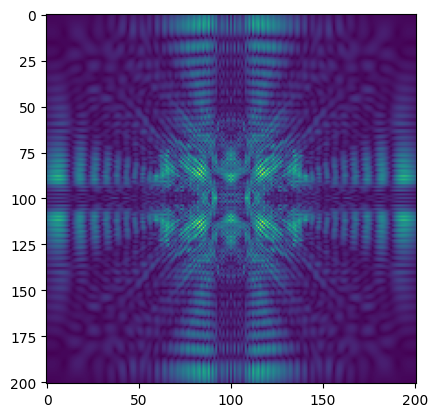

In [2]:

xg,yg = np.meshgrid(mesh.xy.xa,mesh.xy.ya,indexing='ij')

w = mesh.xy.get_weights()

xg0,yg0 = np.meshgrid(mesh.xy.xa0,mesh.xy.ya0,indexing='ij')
w0 = mesh.xy.dx0*mesh.xy.dy0

modes = []
for x,y in zip(xpos,ypos):
    mode = norm_nonu(LPmodes.lpfield(xg-x,yg-y,2,2,rcore/scale,wl0,ncore,nclad),w)
    modes.append(mode)
print(len(modes))
SMFpower=0
print("final field power decomposition:")
for i in range(len(modes)):
    _p = np.power(overlap_nonu(u,modes[i],w),2)
    print("mode"+str(i)+": ", _p)
    SMFpower += _p

print("total power in SMFs: ", SMFpower)

# plotting (optional)
print("final field dist:")
plt.imshow(np.abs(u0)[num_PML:-num_PML,num_PML:-num_PML]) 
plt.show()
